In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install statsmodels

# 資料前處理與讀入(Q1)

In [3]:
# 資料讀入

car_data = pd.read_csv("ToyotaUsedCars.csv")
print(car_data)

               model  year transmission  mileage fuelType  tax   mpg  \
0               GT86  2016       Manual    24089   Petrol  265  36.2   
1               GT86  2017       Manual    18615   Petrol  145  36.2   
2               GT86  2015       Manual    27469   Petrol  265  36.2   
3               GT86  2017       Manual    14736   Petrol  150  36.2   
4               GT86  2017       Manual    36284   Petrol  145  36.2   
...              ...   ...          ...      ...      ...  ...   ...   
6733              IQ  2011    Automatic    30000   Petrol   20  58.9   
6734   Urban Cruiser  2011       Manual    36154   Petrol  125  50.4   
6735   Urban Cruiser  2012       Manual    46000   Diesel  125  57.6   
6736   Urban Cruiser  2011       Manual    60700   Petrol  125  50.4   
6737   Urban Cruiser  2011       Manual    45128   Petrol  125  50.4   

      engineSize  price  
0            2.0  16000  
1            2.0  15995  
2            2.0  13998  
3            2.0  18998  
4    

In [4]:
#切出應變數
X = car_data.iloc[:,:-1].values
Y = car_data.iloc[:,car_data.shape[1]-1].values
print("自變數X:\n",X)
print("應變數Y:\n",Y)

自變數X:
 [[' GT86' 2016 'Manual' ... 265 36.2 2.0]
 [' GT86' 2017 'Manual' ... 145 36.2 2.0]
 [' GT86' 2015 'Manual' ... 265 36.2 2.0]
 ...
 [' Urban Cruiser' 2012 'Manual' ... 125 57.6 1.4]
 [' Urban Cruiser' 2011 'Manual' ... 125 50.4 1.3]
 [' Urban Cruiser' 2011 'Manual' ... 125 50.4 1.3]]
應變數Y:
 [16000 15995 13998 ...  4995  3995  4495]


In [5]:
# 先判斷是否有資料缺失發生
car_data.isnull().any()

,0
model,False
year,False
transmission,False
mileage,False
fuelType,False
tax,False
mpg,False
engineSize,False
price,False


根據結果無資料缺失，故不進行處理

In [6]:
#資料數位化,將此步驟寫成函數形式
def X_encoder(X,rows): # rows代表要進行數位化的欄位，(0,2,4)代表第0,第2,第4列需要數位化
  for row in rows:
    ary_dum = pd.get_dummies(X[:, row]).values.astype("float64")
    X = np.concatenate((X,ary_dum), axis=1)

  i = 0
  for row in rows:
    row -= i
    X = np.delete(X, row, axis=1)
    i += 1

  return X

In [7]:
X = X_encoder(X,(0,2,4))
print(X)




[[2016 24089 265 ... 0.0 0.0 1.0]
 [2017 18615 145 ... 0.0 0.0 1.0]
 [2015 27469 265 ... 0.0 0.0 1.0]
 ...
 [2012 46000 125 ... 0.0 0.0 0.0]
 [2011 60700 125 ... 0.0 0.0 1.0]
 [2011 45128 125 ... 0.0 0.0 1.0]]


應變數為數值資料，故不進行處理

In [8]:
# 切分訓練集&測試集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [9]:
# 特徵縮放
sc_X = StandardScaler().fit(X_train)
X_train = sc_X.transform(X_train)
X_test = sc_X.transform(X_test)

In [10]:
# 印出前處理結果
print("自變數訓練集:")
print(X_train,"\n")
print("應變數訓練集:")
print(Y_train,"\n")
print("自變數測試集:")
print(X_test,"\n")
print("應變數測試集:")
print(Y_test,"\n")

自變數訓練集:
[[-0.81548946 -0.19993468 -1.28400007 ... -0.66595213 -0.12196224
   0.81051346]
 [ 1.03524241 -1.14650953  0.67778175 ... -0.66595213 -0.12196224
   0.81051346]
 [-1.27817243  2.03265222 -0.87811418 ... -0.66595213 -0.12196224
   0.81051346]
 ...
 [ 1.03524241 -1.11681806  0.67778175 ... -0.66595213 -0.12196224
   0.81051346]
 [-3.59158726  2.02363874 -0.87811418 ... -0.66595213 -0.12196224
   0.81051346]
 [-0.35280649 -0.24272222 -1.28400007 ...  1.50160944 -0.12196224
  -1.23378581]] 

應變數訓練集:
[ 6995 13491  4850 ... 11990  3995 11995] 

自變數測試集:
[[-0.35280649  0.61673997 -1.28400007 ...  1.50160944 -0.12196224
  -1.23378581]
 [ 1.03524241 -1.13447388  0.67778175 ... -0.66595213 -0.12196224
   0.81051346]
 [ 1.03524241 -1.01862411  0.67778175 ... -0.66595213 -0.12196224
   0.81051346]
 ...
 [ 0.10987647 -0.09007622  0.67778175 ... -0.66595213 -0.12196224
   0.81051346]
 [ 1.03524241 -0.74625784  0.54248645 ...  1.50160944 -0.12196224
  -1.23378581]
 [-0.35280649 -0.07634391 -1

# 神經網路模型訓練(Q2)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim

In [19]:
import matplotlib.pyplot as plt

In [37]:
from sklearn.metrics import mean_squared_error

In [27]:
# 假設 data_tensor 是你的輸入數據，target_tensor 是你的標籤數據
data_tensor = torch.tensor(X_train)
target_tensor = torch.tensor(Y_train)

# 建立 TensorDataset
dataset = TensorDataset(data_tensor, target_tensor)

# 設定總數據和驗證集比例
train_data_size = int(len(dataset) * 0.8)
val_data_size = len(dataset) - train_data_size

# 將數據集分為訓練集和驗證集
train_data, val_data = random_split(dataset, [train_data_size, val_data_size])

# 建立 DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [36]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# 建立 TensorDataset
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# 建立 DataLoader，設置 batch_size 和不打亂數據
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(X_train.shape[1],84)
    self.fc2 = nn.Linear(84,31)
    self.fc3 = nn.Linear(31,1)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    y = self.fc3(x)
    return y


In [28]:
net = Net()

In [29]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epoch_size = 30

In [34]:
train_loss_history = []
val_loss_history = []

for epoch in range(epoch_size):
    # 訓練模式
    net.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float(), target.float()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = net(data)
        loss = criterion(output, target)

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        # 累積損失
        train_loss += loss.item()

    # 計算並記錄訓練集的平均損失
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # 驗證模式
    net.eval()
    val_loss = 0.0
    with torch.no_grad():  # 禁用梯度計算
        for data, target in val_loader:
            data, target = data.float(), target.float()
            output = net(data)
            loss = criterion(output, target)
            val_loss += loss.item()

    # 計算並記錄驗證集的平均損失
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epoch_size}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch 1/30, Training Loss: 196230096.9412, Validation Loss: 197194643.7647
Epoch 2/30, Training Loss: 192614354.5882, Validation Loss: 191781382.5882
Epoch 3/30, Training Loss: 184726826.5882, Validation Loss: 180631274.3529
Epoch 4/30, Training Loss: 170054506.7059, Validation Loss: 162926768.0000
Epoch 5/30, Training Loss: 149790165.2941, Validation Loss: 139545420.7059
Epoch 6/30, Training Loss: 124814218.1176, Validation Loss: 113730321.8824
Epoch 7/30, Training Loss: 99556277.6471, Validation Loss: 89765168.0000
Epoch 8/30, Training Loss: 77800751.3529, Validation Loss: 71055181.6471
Epoch 9/30, Training Loss: 62565927.5882, Validation Loss: 59087581.6471
Epoch 10/30, Training Loss: 53489308.4706, Validation Loss: 52436426.5882
Epoch 11/30, Training Loss: 48524125.4706, Validation Loss: 49068601.0588
Epoch 12/30, Training Loss: 46361187.4706, Validation Loss: 47296524.3529
Epoch 13/30, Training Loss: 44885314.2647, Validation Loss: 46244654.8235
Epoch 14/30, Training Loss: 4410380

# 驗證是否過度擬合(Q3)

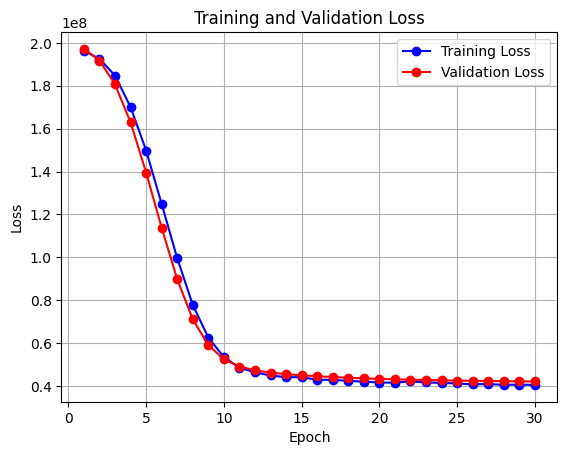

In [35]:
plt.plot(range(1, epoch_size + 1), train_loss_history, label='Training Loss', marker='o', color='b')
plt.plot(range(1, epoch_size + 1), val_loss_history, label='Validation Loss', marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 修正模型epochs(Q4)

只是修改epoch後把前面的程式再寫一次，所以這裡不重複做

# 比較真實值與預測值(Q5) & 印出模型MSE(Q6)

In [42]:
net.eval()

# 初始化列表，用於儲存預測值和真實值
predictions = []
actuals = []

# 禁用梯度計算（測試時不需要反向傳播）
with torch.no_grad():
    for data, target in test_loader:
        # 將數據轉為 Float 類型
        data, target = data.float(), target.float()

        # 將數據送入模型
        output = net(data)
        predicted = output

        # 添加到列表中
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(target.cpu().numpy())

# 計算並顯示模型的評估指標
mse = mean_squared_error(actuals, predictions)
print(f'Test MSE: {mse:.4f}')
print(f'Test RMSE: {mse ** 0.5:.4f}')

Test MSE: 41957948.0000
Test RMSE: 6477.4955


In [41]:
for i in range(10):  # 僅顯示前 10 筆
    print(f'Actual: {actuals[i]}, Predicted: {predictions[i]}')

Actual: 11295.0, Predicted: [12017.032]
Actual: 18995.0, Predicted: [12290.86]
Actual: 8950.0, Predicted: [13553.61]
Actual: 9995.0, Predicted: [13034.415]
Actual: 15990.0, Predicted: [12234.911]
Actual: 9991.0, Predicted: [12166.889]
Actual: 9990.0, Predicted: [12433.314]
Actual: 8495.0, Predicted: [11447.249]
Actual: 10995.0, Predicted: [12208.934]
Actual: 20795.0, Predicted: [15152.944]
